In [1]:
cd /g/data/jk72/deg581/vanom/ana/notebooks

/g/data/jk72/deg581/vanom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/130863001.gadi-pbs'

In [3]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

In [4]:
grd = xr.open_dataset('/g/data/jk72/deg581/vanderford-setup/data/proc/vand_2km_v5_lb_grd.nc')


In [29]:


FilePath='/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/' # Truth file settings
prefix='roms_his_'
timeRange = [1,11]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['rho','u','v','Tb','Sb','ubar','vbar','w','salt','shflux','ssflux','sustr','svstr','AKv','AKt','Hsbl'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

# plt.figure(figsize=(15,15))
# ds.mask_zice.plot(x='x_rho',y='y_rho')
# plt.grid()
poly_shelf = np.array([
    [2.38e6,-900000],
    [2.38e6,-925000],
    [2.4e6,-925000],
    [2.43e6,-912800],
    [2.43e6,-900000],
    [2.42e6,-887500],
	[2.40e6,-890000],
    [2.38e6,-900000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()


mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])

ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'vanderford'
ds.mask_zice_roi.attrs['long_name']=roi_label1
# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w0,axis=0))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


print('mapping u/v to u/v rho')
# ds['u_rho'] = grid.interp(ds.u,'X')
# ds['v_rho'] = grid.interp(ds.v,'Y')


['/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0001.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0002.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0003.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0004.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0005.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0006.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0007.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0008.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0009.nc', '/g/data/jk72/deg581/vanom/mdl/vanderford_v5_bm3/roms_his_0010.nc']
4.186153836 G
0.569946544 G
making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt
mapping u/v to u/v rho


In [30]:
ds.load()
ds

<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 25, s_w: 26,
                        eta_rho: 110, xi_rho: 61, xi_u: 60, eta_v: 109,
                        ocean_time: 731)
Coordinates: (12/15)
  * s_rho              (s_rho) float64 -0.98 -0.94 -0.9 ... -0.1 -0.06 -0.02
  * s_w                (s_w) float64 -1.0 -0.96 -0.92 -0.88 ... -0.08 -0.04 0.0
    x_rho              (eta_rho, xi_rho) float64 2.379e+06 ... 2.499e+06
    y_rho              (eta_rho, xi_rho) float64 -9.39e+05 ... -7.21e+05
    x_u                (eta_rho, xi_u) float64 2.38e+06 2.382e+06 ... 2.498e+06
    y_u                (eta_rho, xi_u) float64 -9.39e+05 -9.39e+05 ... -7.21e+05
    ...                 ...
    y_psi              (eta_v, xi_u) float64 -9.38e+05 -9.38e+05 ... -7.22e+05
  * ocean_time         (ocean_time) datetime64[ns] 2007-01-01 ... 2016-12-29
    lon_rho            (eta_rho, xi_rho) float64 111.5 111.5 ... 106.1 106.1
    lat_rho            (eta_rho, xi_rho) float64 -66.77 -66.75 ... -66.41 -66.39
    z_w0               (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    z_rho0             (s_rho, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/96)
    ntimes             int32 1051200
    ndtfast            int32 30
    dt                 float64 30.0
    dtfast             float64 1.0
    dstart             datetime64[ns] 2007-01-01
    nHIS               int32 14400
    ...                 ...
    dx_psi             (eta_v, xi_u) float64 1.967e+03 1.967e+03 ... 1.964e+03
    dy                 (eta_rho, xi_rho) float64 1.965e+03 ... 1.962e+03
    dy_u               (eta_rho, xi_u) float64 1.965e+03 1.965e+03 ... 1.962e+03
    dy_v               (eta_v, xi_rho) float64 1.965e+03 1.965e+03 ... 1.962e+03
    dy_psi             (eta_v, xi_u) float64 1.965e+03 1.965e+03 ... 1.962e+03
    dA                 (eta_rho, xi_rho) float64 3.865e+06 ... 3.855e+06
Attributes: (12/34)
    file:              roms_his_0001.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Vanderford Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            012x016
    history:           ROMS/TOMS, Version 4.1, Wednesday - December 11, 2024 ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_in...
    CPP_options:       VANDERFORD, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL, ANA_S...

# melt rates

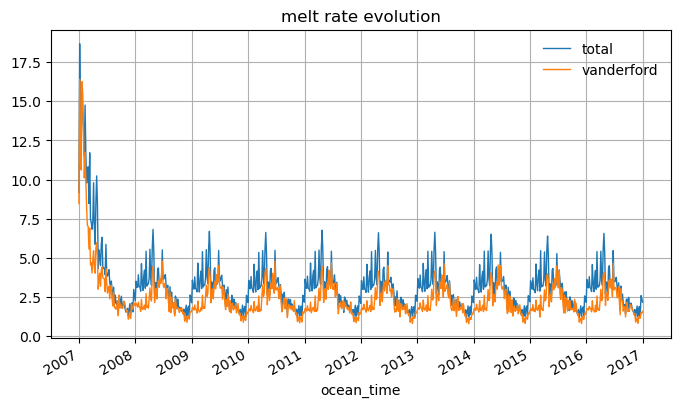

In [31]:
# time evolution of melt rate
plt.figure(figsize=(8,4))
(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='total')
(ds.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='vanderford')
plt.legend(frameon=False)
plt.title('melt rate evolution')
plt.grid()
plt.show()


<Figure size 640x480 with 0 Axes>

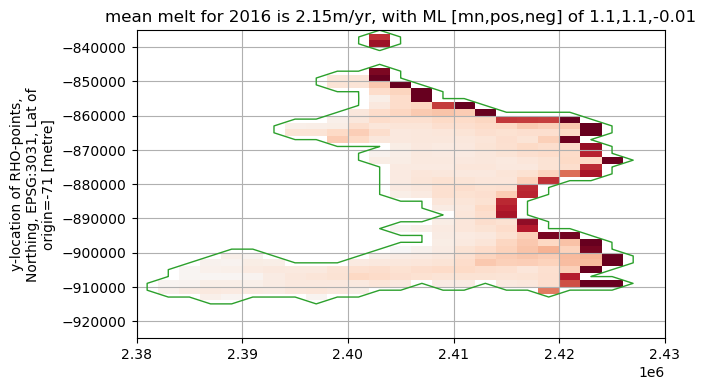

In [40]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,4])
ax = None

year_start='2016-01-01'
year_end = '2017-01-01'

ax=fig.add_subplot(gs[0,0])

im=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',add_colorbar=False,vmin=-10,vmax=10)
co = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
# co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[0],colors='k')
ax.axis((2.38e6,2.43e6,-.925e6,-.835e6))
ii=ii+1

ml_tot=str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_neg =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))<0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_pos =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))>0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
melt_mn =str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ax.set_title('mean melt for '+str(year)+' is '+melt_mn+ 'm/yr, with ML [mn,pos,neg] of '+ml_tot+','+ml_pos+','+ml_neg)
ax.set_xlabel('')

# plt.colorbar(im,orientation='horizontal')
plt.grid()
plt.show()


In [55]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.ticker as mticker

Text(0.5, 0, 'melt rate (m/yr)')

<Figure size 640x480 with 0 Axes>

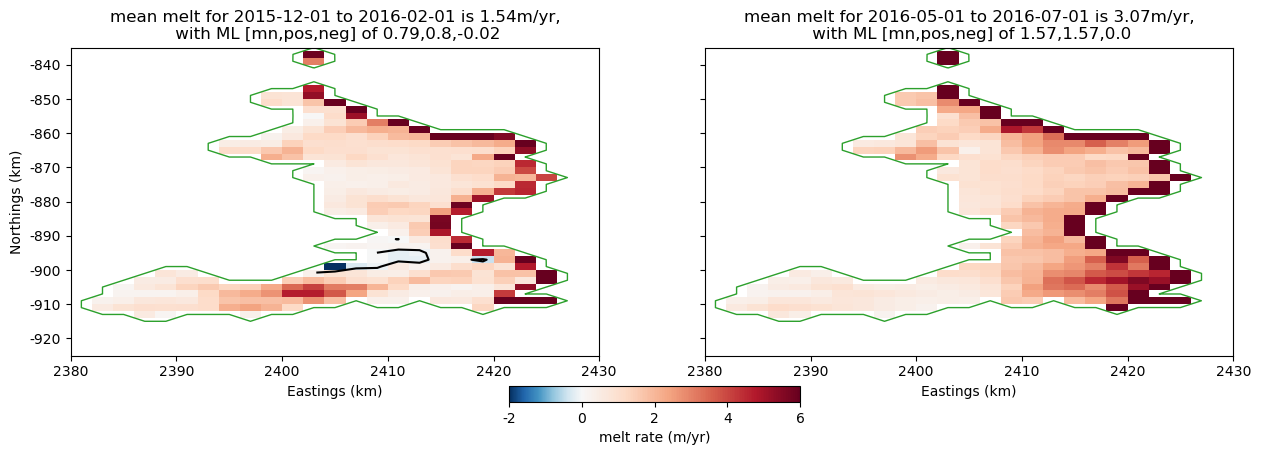

In [65]:
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,4])
ax = None
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.05)


year_start='2015-12-01'
year_end = '2016-02-01'

ax=fig.add_subplot(gs[0,0])

im=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',add_colorbar=False,norm=TwoSlopeNorm(vmin=-2,vcenter=0,vmax=6),
                                                                                                       vmin=-2,vmax=6)
co = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
# co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[0],colors='k')
ax.axis((2.38e6,2.43e6,-.925e6,-.835e6))

ml_tot=str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_neg =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))<0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_pos =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))>0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
melt_mn =str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ax.set_title('mean melt for '+year_start+' to '+year_end+' is '+melt_mn+ 'm/yr,\n with ML [mn,pos,neg] of '+ml_tot+','+ml_pos+','+ml_neg)

ax.set_xlabel('Eastings (km)')
ax.set_ylabel('Northings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
# ax.set_yticklabels([])


ax=fig.add_subplot(gs[0,1])

year_start='2016-05-01'
year_end = '2016-07-01'

im=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',add_colorbar=False,norm=TwoSlopeNorm(vmin=-2,vcenter=0,vmax=6),
                                                                                                       vmin=-2,vmax=6)
co = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
# co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[0],colors='k')
ax.axis((2.38e6,2.43e6,-.925e6,-.835e6))

ml_tot=str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_neg =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))<0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_pos =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))>0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
melt_mn =str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ax.set_title('mean melt for '+year_start+' to '+year_end+' is '+melt_mn+ 'm/yr,\n with ML [mn,pos,neg] of '+ml_tot+','+ml_pos+','+ml_neg)

ax.set_xlabel('Eastings (km)')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_yticklabels([])

cax = inset_axes(ax,
                width="55%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(-.37,-0.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal',ticks=[-2,0,2,4,6])
cbar.ax.set_xscale('linear')
tick_locations = [-2, 0, 2,4,6]
cbar.set_ticks(tick_locations)  # Force tick locations
cbar.ax.set_xticklabels([-2,0,2,4,6])
cbar.ax.set_xlabel(r'melt rate (m/yr)')#,fontsize=14)


<Figure size 640x480 with 0 Axes>

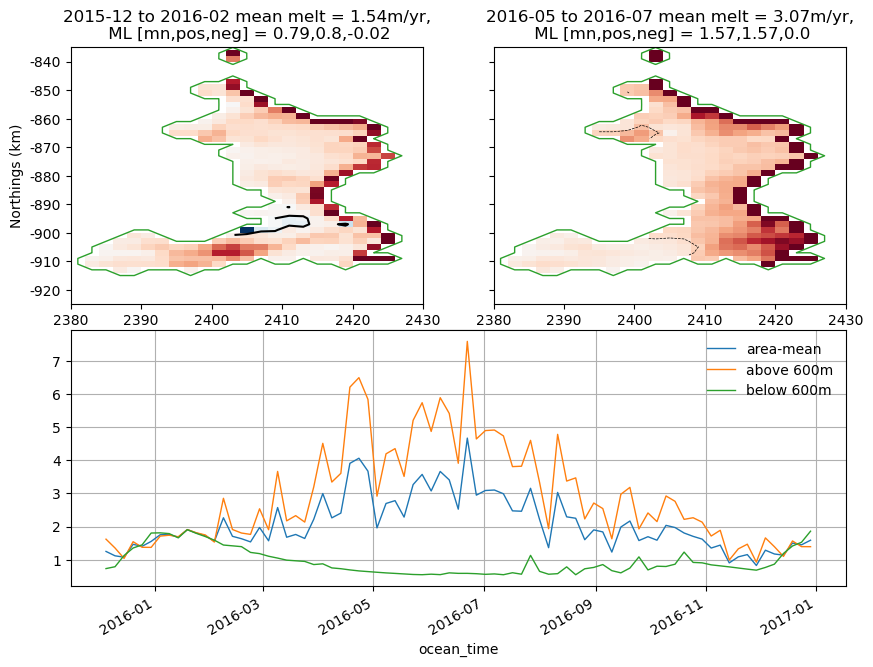

In [96]:
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,7])
ax = None
gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.2, hspace=0.1)


year_start='2015-12-01'
year_end = '2016-02-01'

ax=fig.add_subplot(gs[0,0])

im=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',add_colorbar=False,norm=TwoSlopeNorm(vmin=-2,vcenter=0,vmax=6),
                                                                                                       vmin=-2,vmax=6)
co = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
# co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[0],colors='k')
ax.axis((2.38e6,2.43e6,-.925e6,-.835e6))

ml_tot=str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_neg =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))<0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_pos =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))>0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
melt_mn =str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ax.set_title(''+year_start[:-3]+' to '+year_end[:-3]+' mean melt = '+melt_mn+ 'm/yr,\n ML [mn,pos,neg] = '+ml_tot+','+ml_pos+','+ml_neg)

ax.set_xlabel('Eastings (km)')
ax.set_ylabel('Northings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
# ax.set_yticklabels([])


ax=fig.add_subplot(gs[0,1])

year_start='2016-05-01'
year_end = '2016-07-01'

im=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',add_colorbar=False,norm=TwoSlopeNorm(vmin=-2,vcenter=0,vmax=6),
                                                                                                       vmin=-2,vmax=6)
co = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
co = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_ziceNaN,levels=[-600],colors='k',linestyles='--',linewidths=0.5)

co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[0],colors='k')
ax.axis((2.38e6,2.43e6,-.925e6,-.835e6))

ml_tot=str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_neg =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))<0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ml_pos =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))>0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
melt_mn =str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
ax.set_title(''+year_start[:-3]+' to '+year_end[:-3]+' mean melt = '+melt_mn+ 'm/yr,\n ML [mn,pos,neg] = '+ml_tot+','+ml_pos+','+ml_neg)

ax.set_xlabel('Eastings (km)')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_yticklabels([])

cax = inset_axes(ax,
                width="55%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(-.37,-0.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal',ticks=[-2,0,2,4,6])
cbar.ax.set_xscale('linear')
tick_locations = [-2, 0, 2,4,6]
cbar.set_ticks(tick_locations)  # Force tick locations
cbar.ax.set_xticklabels([-2,0,2,4,6])
cbar.ax.set_xlabel(r'melt rate (m/yr)')#,fontsize=14)


ax=fig.add_subplot(gs[1,:])

(ds.my.sel(ocean_time=slice('2015-12-01','2017-01-01'))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='area-mean')
(ds.my.where(ds.zice>-600).sel(ocean_time=slice('2015-12-01','2017-01-01'))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='above 600m')
(ds.my.where(ds.zice<=-600).sel(ocean_time=slice('2015-12-01','2017-01-01'))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='below 600m')

ax.legend(frameon=False)
plt.grid()
plt.show()



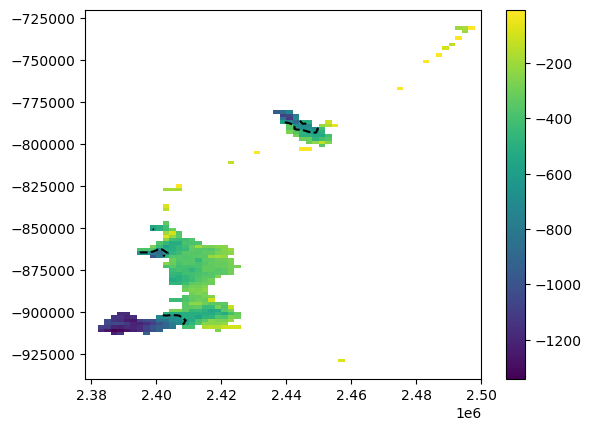

In [94]:
plt.pcolormesh(ds.x_rho,ds.y_rho,ds.zice*ds.mask_ziceNaN)
plt.colorbar()
plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_ziceNaN,levels=[-600],colors='k')


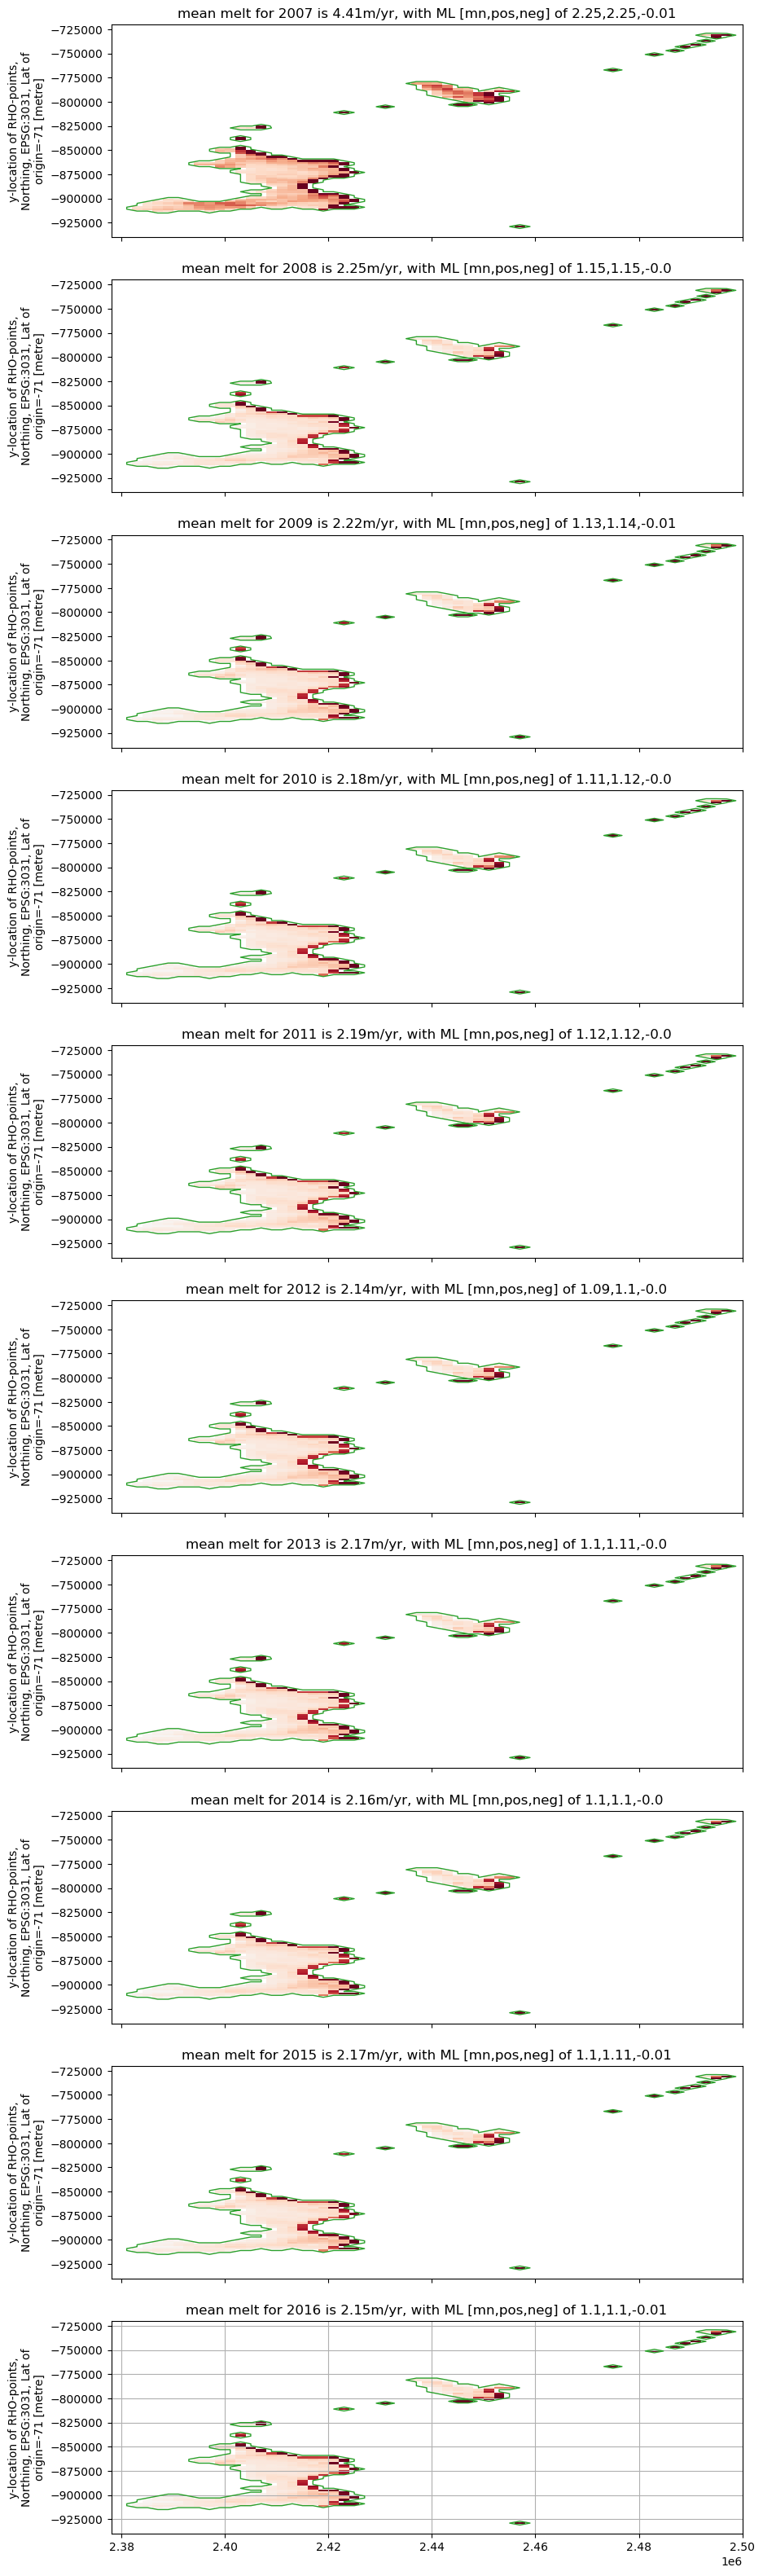

In [66]:
year_list = range(2007,2017,1)


fig, axes = plt.subplots(nrows=len(year_list), ncols=1, sharex=True, sharey=True, figsize=(10,40))
newcmap = cmocean.tools.crop(cmocean.cm.balance,vmin=-5,vmax=40,pivot=0)
axes_list = axes.reshape(-1)

ii=0
for year in year_list:
    ax = axes_list[ii]
    
    year_start = str(year)+'-01-01'
    year_end = str(year+1)+'-01-01'
    im=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',add_colorbar=False,vmin=-10,vmax=10)
    co = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
    # co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

    co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[0],colors='k')
    # ax.axis((1.65e6,2.4e6,.6e6,.84e6))
    ii=ii+1
    
    ml_tot=str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
    ml_neg =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))<0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
    ml_pos =str((ds.my.sel(ocean_time=slice(year_start,year_end)).where(ds.my.sel(ocean_time=slice(year_start,year_end))>0,np.NaN)*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)*ds.dA*917*1e-12).sum(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
    melt_mn =str((ds.my.sel(ocean_time=slice(year_start,year_end))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').round(2).values)
    ax.set_title('mean melt for '+str(year)+' is '+melt_mn+ 'm/yr, with ML [mn,pos,neg] of '+ml_tot+','+ml_pos+','+ml_neg)
    ax.set_xlabel('')

# plt.colorbar(im,orientation='horizontal')
plt.grid()
plt.show()


# ocean heat content

In [35]:
# plot heat content
#OHC = rho0*cp0*dV*dT
dV = (1/ds.pm)*(1/ds.pn)*ds.dz
rho0=1026
cp0=4181.3
OHC=1026*4181.3*dV*(ds.temp+273.15)


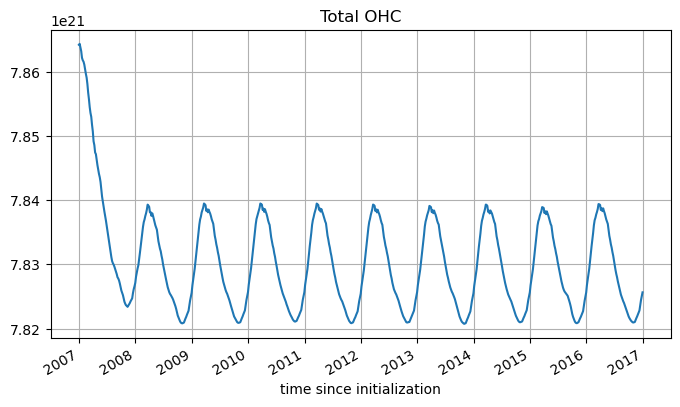

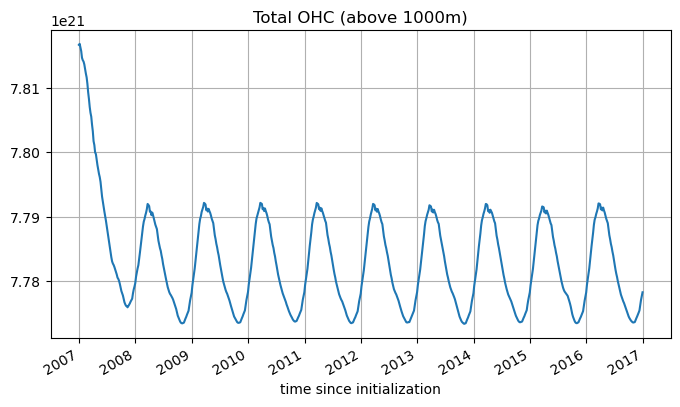

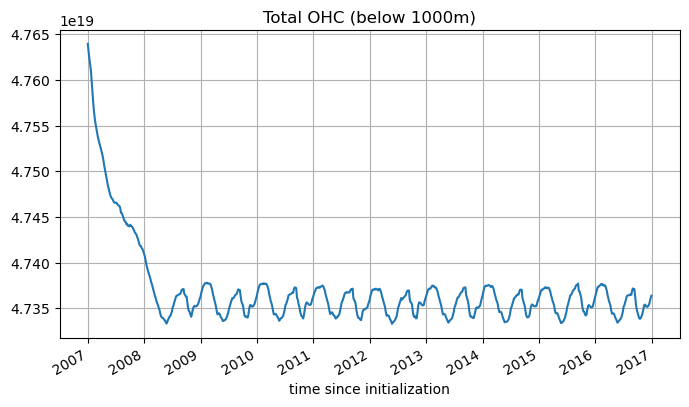

In [36]:
# plot total OHC
TotalOHC = OHC.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
plt.figure(figsize=(8,4))
TotalOHC.plot()
plt.title('Total OHC')
plt.grid()
plt.show()
TotalOHC_above1000 = OHC.where((ds.z_rho0>-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
plt.figure(figsize=(8,4))
TotalOHC_above1000.plot()
plt.title('Total OHC (above 1000m)')
plt.grid()
plt.show()
TotalOHC_below1000 = OHC.where((ds.z_rho0<-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
plt.figure(figsize=(8,4))
TotalOHC_below1000.plot()
plt.title('Total OHC (below 1000m)')
plt.grid()

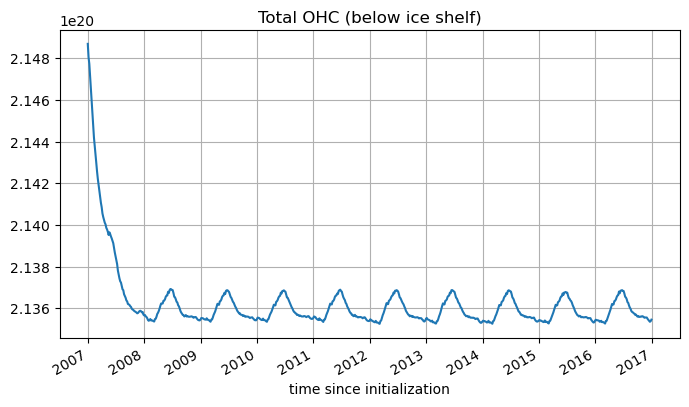

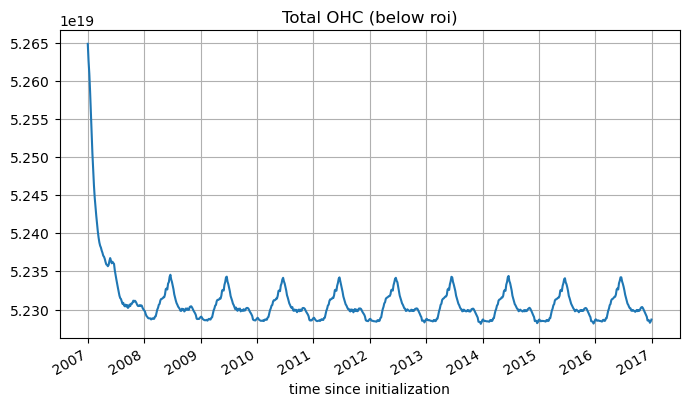

In [37]:
# plot under ice OHC

TotalOHC_subIce = OHC.where(ds.mask_zice.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
plt.figure(figsize=(8,4))
TotalOHC_subIce.plot()
plt.title('Total OHC (below ice shelf)')
plt.grid()
TotalOHC_subIce_roi = OHC.where(ds.mask_zice_roi.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
plt.figure(figsize=(8,4))
TotalOHC_subIce_roi.plot()
plt.title('Total OHC (below roi)')
plt.grid()
